In [1]:
!pip install requests

You should consider upgrading via the 'pip install --upgrade pip' command.


In [196]:
import requests as requests
import pandas as pd
import time as time
import numpy as np

In [116]:
def get_search_listings_query(
    localid,
    area_min,
    price_max,
    batch_size,
    offset
):
    return """
    {
    searchListings(search: {
                                housingFormGroups: APARTMENTS, 
                                typeGroups: COOPERATIVE, 
                                locationIds: [%s], 
                                livingAreaMin: %s, 
                                priceMax: %s 
                            }, 
                            limit: %s, 
                            offset: %s ) {
        listings {
          id
          title
          streetAddress
          isForSale
          relevantAmenities {
            isAvailable
            kind
          }
          isUpcoming
          listingHemnetUrl
          legacyConstructionYear
          livingArea
          area
          landArea
          numberOfRooms
          floorPlanImages {
            url
          }
          askingPrice {
            amount
          }
          squareMeterPrice {
            amount
          }
          askingPrice {
            amount
          }
          fee {
            amount
          }
          coordinates {
            lat
            long
          }
          broker {
            name
            email
            phoneNumber
          }
          locations {
            name
            id
          }
        }
      }
    }
    """ % (
        localid,
        area_min,
        price_max,
        batch_size,
        offset
    )

In [149]:
def get_sold_listings_query(
    localid,
    area_min,
    price_max,
    batch_size,
    offset
):
    return """
    {
    searchSoldListings(search: {housingFormGroups: APARTMENTS, 
                                typeGroups: COOPERATIVE, 
                                locationIds: [%s], 
                                livingAreaMin: %s, 
                                priceMax: %s
                                }, 
                                limit: %s, 
                                offset: %s) {
    listings {
      id
      priceChange {
        amount
      }
      runningCosts {
        amount
      }
      streetAddress
      legacyConstructionYear
      livingArea
      area
      landArea
      numberOfRooms
      askingPrice {
        amount
      }
      askingPrice {
        amount
      }
      fee {
        amount
      }
      coordinates {
        lat
        long
      }
      broker {
        name
        email
        phoneNumber
      }
    }
  }
}

    """ % (
        localid,
        area_min,
        price_max,
        batch_size,
        offset
    )

In [ ]:
requests.post("https://www.hemnet.se/graphql", data={ 'query': get_sold_listings_query(localid, area_min, price_max, batch_size, offset) }).json()

In [186]:
# batch_size = 10
# offset = 0
localid = 898740 #bromma
area_min = 20
price_max = 6000000

def extract_listings(function, search_listings, batch_size, n):
    
    offset = 0
    batch_size = batch_size
    listing = pd.DataFrame()
    
    while offset < n:
        query = function(localid, area_min, price_max, batch_size, offset)
        response = requests.post("https://www.hemnet.se/graphql", data={ 'query': query }).json()
        df = pd.DataFrame.from_dict(response['data'][search_listings]['listings'])
        listing = pd.concat([listing, df])
        offset += batch_size
        time.sleep(3)
        
    return listing    


In [187]:
df = extract_listings(get_sold_listings_query, 'searchSoldListings', 50, 200)

In [188]:
df.head()

,id,priceChange,runningCosts,streetAddress,legacyConstructionYear,livingArea,area,landArea,numberOfRooms,askingPrice,fee,coordinates,broker
0,1220580,{'amount': 450000},{'amount': 4400},Svartviksslingan 67,1984,61.5,Bromma / Minneberg,None,2.0,{'amount': 3450000},{'amount': 3275},"{'lat': 59.339932151472716, 'long': 17.9920555...","{'name': 'Emma Andersson Hejll', 'email': 'emm..."
1,1220531,{'amount': 305000},None,"Klädesvägen 34, vån 4/4",2015,45.0,Bromma Brommaplan,None,2.0,{'amount': 2495000},{'amount': 2550},"{'lat': 59.33822299724113, 'long': 17.94362119...","{'name': 'Lawan Farag', 'email': 'lawan.farag@..."
2,1220419,{'amount': 425000},{'amount': 8280},Alpvägen 17,2016,83.0,Bromma - Annedal,None,3.0,{'amount': 3895000},{'amount': 4309},"{'lat': 59.36218431761735, 'long': 17.95293200...","{'name': 'Ylva Gauffin', 'email': 'ylva.gauffi..."
3,1219499,{'amount': 150000},{'amount': 3600},Alpvägen 10,1975,28.7,Bromma / Mariehäll,None,1.0,{'amount': 1750000},{'amount': 2551},"{'lat': 59.3623248538899, 'long': 17.954264386...","{'name': 'Hevrê Yildiz', 'email': 'hevre.yildi..."
4,1219465,{'amount': 305000},{'amount': 4300},"Kratsbodavägen 50B, 6tr",2016,54.0,Bromma / Mariehäll,None,2.0,{'amount': 2995000},{'amount': 3148},"{'lat': 59.36126681319138, 'long': 17.95455959...","{'name': 'Mose Sundlöv', 'email': 'mose.sundlo..."


In [189]:
df = df.dropna(subset=['priceChange', 'askingPrice']).reset_index()

In [ ]:
df['price/sqm'] = df.squareMeterPrice.apply(lambda x: x['amount'])
df['asking_price'] = df.askingPrice.apply(lambda x: x['amount'])
df['monthly_fee'] = df.fee.apply(lambda x: x['amount'] if x else 0 )
df['has_balcony'] = df.relevantAmenities.apply(lambda x: x[0]['isAvailable'])
df['has_elevator'] = df.relevantAmenities.apply(lambda x: x[1]['isAvailable'])

In [190]:
df['asking_price'] = df.askingPrice.apply(lambda x: x['amount'])
df['price_change'] = df.priceChange.apply(lambda x: x['amount'])
df['price/sqm'] = (df['price_change']+df['asking_price'])/df.livingArea

In [193]:
df.head()

,index,id,priceChange,runningCosts,streetAddress,legacyConstructionYear,livingArea,area,landArea,numberOfRooms,askingPrice,fee,coordinates,broker,asking_price,price_change,price/sqm
0,0,1220580,{'amount': 450000},{'amount': 4400},Svartviksslingan 67,1984,61.5,Bromma / Minneberg,None,2.0,{'amount': 3450000},{'amount': 3275},"{'lat': 59.339932151472716, 'long': 17.9920555...","{'name': 'Emma Andersson Hejll', 'email': 'emm...",3450000,450000,63414.634146
1,1,1220531,{'amount': 305000},None,"Klädesvägen 34, vån 4/4",2015,45.0,Bromma Brommaplan,None,2.0,{'amount': 2495000},{'amount': 2550},"{'lat': 59.33822299724113, 'long': 17.94362119...","{'name': 'Lawan Farag', 'email': 'lawan.farag@...",2495000,305000,62222.222222
2,2,1220419,{'amount': 425000},{'amount': 8280},Alpvägen 17,2016,83.0,Bromma - Annedal,None,3.0,{'amount': 3895000},{'amount': 4309},"{'lat': 59.36218431761735, 'long': 17.95293200...","{'name': 'Ylva Gauffin', 'email': 'ylva.gauffi...",3895000,425000,52048.192771
3,3,1219499,{'amount': 150000},{'amount': 3600},Alpvägen 10,1975,28.7,Bromma / Mariehäll,None,1.0,{'amount': 1750000},{'amount': 2551},"{'lat': 59.3623248538899, 'long': 17.954264386...","{'name': 'Hevrê Yildiz', 'email': 'hevre.yildi...",1750000,150000,66202.090592
4,4,1219465,{'amount': 305000},{'amount': 4300},"Kratsbodavägen 50B, 6tr",2016,54.0,Bromma / Mariehäll,None,2.0,{'amount': 2995000},{'amount': 3148},"{'lat': 59.36126681319138, 'long': 17.95455959...","{'name': 'Mose Sundlöv', 'email': 'mose.sundlo...",2995000,305000,61111.111111


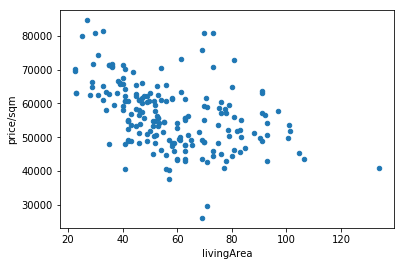

In [192]:
df.plot.scatter('livingArea', 'price/sqm')

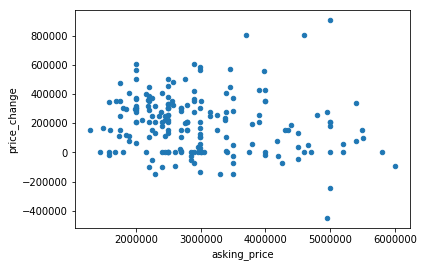

In [207]:
df.plot.scatter('asking_price', 'price_change')

In [202]:
def calc_average_price_per_sqm(living_area):
    mean_price = df[df.livingArea.isin(np.arange((living_area-10), (living_area+10)))][['price/sqm']].mean()
    return mean_price

In [205]:
calc_average_price_per_sqm(40)

price/sqm    60698.707532
dtype: float64

In [184]:
df.groupby('area').mean()['price/sqm'].sort_values(ascending=False)

area
Smedslätten                  80714.285714
Äppelviken                   75797.101449
Norra Ängby                  72839.506173
Bromma Alvik - Äppelviken    72077.922078
Traneberg                    66983.979572
Bromma / Minneberg           63414.634146
Bromma / Traneberg           62024.656637
Bromma Åkeshov Brommaplan    60714.285714
Åkeslund                     59493.670886
Bromma Traneberg             59032.215957
Bromma/Mariehäll             58802.816901
Minneberg                    58383.595811
Bromma - Åkeslund            58333.333333
Bromma / Mariehäll           58167.170497
Bromma - Traneberg           57547.169811
Bromma Annedal/Mariehäll     57340.598569
Bromma Ålsten                57236.842105
Abrahamsberg                 56934.523810
Bromma - Ulvsunda            56483.516484
Olovslund / Abrahamsberg     55925.925926
Mariehäll                    55263.790665
Bromma Minneberg             55158.730159
Bromma Mariehäll             55155.770075
Bromma Åkeshov               